In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import sampler, Subset
from torch.optim import lr_scheduler

import torchvision.datasets as dset
import torchvision.transforms as T

from PIL import Image

# constants
repo_path = Path('/Users/etriesch/dev/tree-finder/')
model_path = repo_path / 'models'

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing 

In [2]:
# setup computing
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cpu


In [3]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# define paths
repo_path = Path('git/tree-finder/')
full_repo_path = Path('/content/drive/My Drive ') / repo_path
model_path = full_repo_path / 'models'

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(repo_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# setup cell
from notebooks.plot_fns import show_image_batch, set_plt_settings, plot_accs
from notebooks.train_fns import flatten, Flatten, train_model
from notebooks.data_processing import define_transforms, make_dataloaders, IMAGE_DIM, MEAN, STD
from notebooks.models import ResnetBinClassifier
from notebooks.scrape_fns import get_filelist

# And change jupyter settings to auto-reload these functions before each instance running them
%load_ext autoreload
%autoreload 2

In [5]:
set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [6]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=True)
# create dataset by concatenating all transformations
treeds = []
for t in transforms:
    df = dset.ImageFolder(root=full_repo_path / 'data/images_spec', transform=transforms[t])
    treeds.append(df)

treeds = ConcatDataset(treeds)
class_names = treeds.datasets[0].classes

In [7]:
# make dataloaders
N = len(treeds)

# make whole-dataset loader and subset loader
loader_all = DataLoader(dataset=treeds, batch_size=N, shuffle=False)
loader_small = DataLoader(dataset=treeds, batch_size=25, 
                          sampler=sampler.SubsetRandomSampler(range(0, 500)))
loader_samp = DataLoader(dataset=treeds, batch_size=4, shuffle=True)

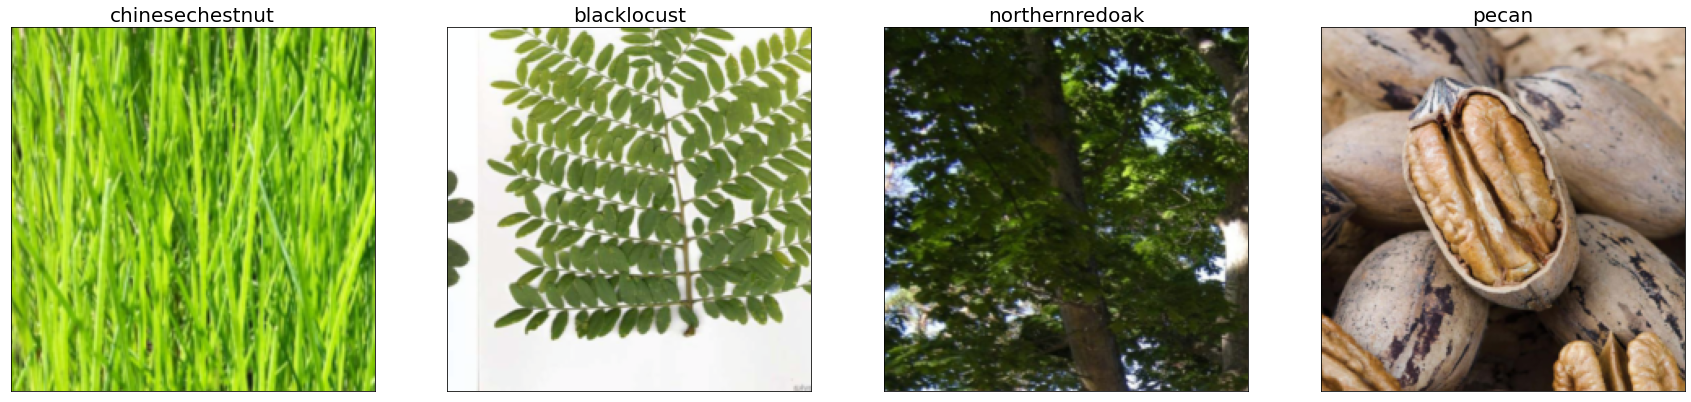

In [8]:
# visualize images
samp_imgs, samp_classes = next(iter(loader_samp))

# print(type(imgs), type(labels))
show_image_batch(samp_imgs, MEAN, STD, title=[class_names[x] for x in samp_classes])

# Subset dataset to images that a binary classifier classifies as trees

In [9]:
# load binary classifier
model = ResnetBinClassifier(resnet50=True)
model.load_state_dict(torch.load(model_path / 'ResnetBinClassifier.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()

# load all images
loader = loader_small
batch = loader.batch_size
N = batch * len(loader)
X_in, __ = next(iter(loader))
# mount to right processor
X_in = X_in.to(device=device, dtype=dtype)  # move to device, e.g. GPU

loading pretrained resnet50...


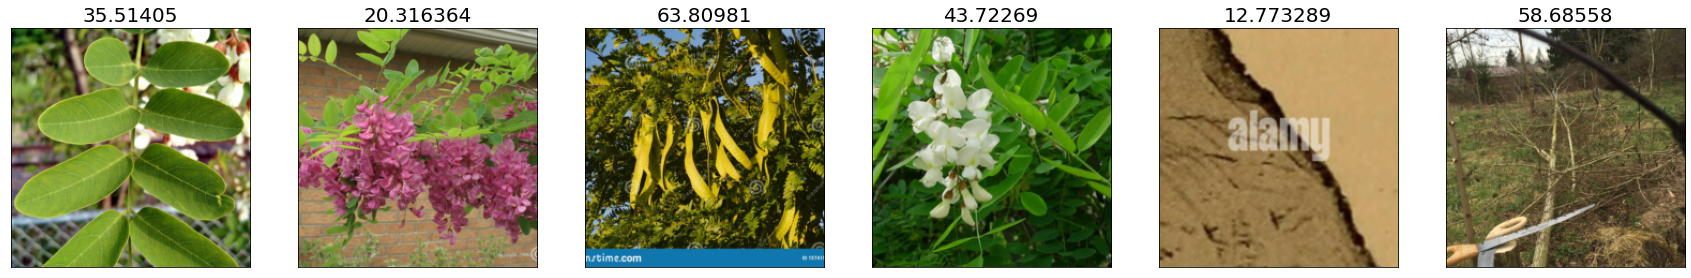

In [10]:
# get scores for all images
scores = model(X_in)
percentage = F.softmax(scores, dim=1) * 100

# print trees and score for detecting tree for a random sample of images
display_idxs = np.random.choice(range(batch), 6, replace=False)
tree_likelihood = percentage[:,1].detach().cpu().numpy()
show_image_batch(X_in[display_idxs].cpu(), MEAN, STD, title=tree_likelihood[display_idxs])

In [11]:
# subset to images that pass tree threshold
tree_class_threshold = 0.55
tree_idxs = np.arange(0, batch)[tree_likelihood >= tree_class_threshold].tolist()

# subset the dataset
treeds_sub = torch.utils.data.Subset(treeds, tree_idxs)

In [12]:
# make dataloaders with the subset data
dataloaders, ds_sizes = make_dataloaders(dataset=treeds, test_split=0.10, val_split=0.25, sampleN=4, batch_size=32, seed=None)
# dataloaders, ds_sizes = make_dataloaders(dataset=treeds_sub, test_split=0.10, val_split=0.25, sampleN=4, batch_size=32, seed=None)

dataloader sizes: {'all': 32832, 'train': 22161, 'validate': 7387, 'test': 3284, 'sampler': 4}


# Summarize original, augmented, and subset datasets

In [13]:
tree_filelist = get_filelist(full_repo_path / 'data/images_spec')

In [14]:
tree_summary = dict.fromkeys(tree_filelist.keys(), [0,0,0,0])
for k, i in tree_filelist.items():
  a = np.array(i)
  count_all = len(a)
  count_bing = len(a[np.char.startswith(a, 'bing-')])
  count_arbor = len(a[np.char.startswith(a, 'arborday-')])
  count_harvard = len(a[np.char.startswith(a, 'harvard-')])
  tree_summary[k] = [count_all, count_bing, count_arbor, count_harvard]

In [15]:
print('original dataset (all, bing, arborday, harvard):')
print(tree_summary)
print('augmented dataset:')
tree_summary_aug = tree_summary
for k in tree_summary.keys():
  tree_summary_aug[k] = [d*8 for d in tree_summary[k]]
print(tree_summary_aug)
print('filtered dataset: TBD')


original dataset (all, bing, arborday, harvard):
{'blacklocust': [605, 562, 0, 43], 'blackwalnut': [651, 563, 4, 84], 'northernredoak': [579, 531, 7, 41], 'loblollypine': [495, 488, 7, 0], 'chinesechestnut': [662, 467, 3, 192], 'honeylocust': [501, 501, 0, 0], 'pecan': [611, 591, 6, 14]}
augmented dataset:
{'blacklocust': [4840, 4496, 0, 344], 'blackwalnut': [5208, 4504, 32, 672], 'northernredoak': [4632, 4248, 56, 328], 'loblollypine': [3960, 3904, 56, 0], 'chinesechestnut': [5296, 3736, 24, 1536], 'honeylocust': [4008, 4008, 0, 0], 'pecan': [4888, 4728, 48, 112]}
filtered dataset: TBD


# Move to new notebook after I can figure out how to save filtered data
# Baseline models

In [16]:
# define small loader for testing
small_data_train_size = 100
small_data_validate_size = 50
small_batch_size = 10
small_loaders = {}
small_loaders['train'] = DataLoader(treeds, batch_size=small_batch_size,
                           sampler=sampler.SubsetRandomSampler(np.random.randint(0, len(treeds), small_data_train_size)))
small_loaders['validate'] = DataLoader(treeds, batch_size=small_batch_size,
                           sampler=sampler.SubsetRandomSampler(np.random.randint(0, len(treeds), small_data_validate_size)))
small_ds_sizes = {'train':small_data_train_size, 'validate':small_data_validate_size}

# define loader to be used below
loaders = small_loaders
sizes = small_ds_sizes
# loaders = dataloaders
# sizes = ds_sizes

# define num epochs
num_epochs = 3

### Random guessing

In [18]:
mr_random = 1 / len(class_names)
print(mr_random)

0.14285714285714285


## Softmax

In [19]:
# define the model, optimizer, and scheduler (for lr decay)
model_sm = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, len(class_names)),
    nn.Softmax(dim=1)
    ).to(device)
optimizer_sm = optim.SGD(model_sm.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr_sm = lr_scheduler.StepLR(optimizer_sm, step_size=2, gamma=0.1) # lr decay
criterion_sm = nn.NLLLoss()

train epoch: [1/3] Loss: -0.1053 ACC@1: 9.00%: 100%|██████████| 10/10 [01:30<00:00,  9.08s/it]
validate epoch: [1/3] Loss: -0.1864 ACC@1: 18.00%: 100%|██████████| 5/5 [00:33<00:00,  6.60s/it]
train epoch: [2/3] Loss: -0.2309 ACC@1: 23.00%: 100%|██████████| 10/10 [01:01<00:00,  6.13s/it]
validate epoch: [2/3] Loss: -0.1778 ACC@1: 18.00%: 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]
train epoch: [3/3] Loss: -0.2853 ACC@1: 28.00%: 100%|██████████| 10/10 [01:03<00:00,  6.35s/it]
validate epoch: [3/3] Loss: -0.1786 ACC@1: 18.00%: 100%|██████████| 5/5 [00:22<00:00,  4.57s/it]



Returning best model, with validation accuracy 0.18


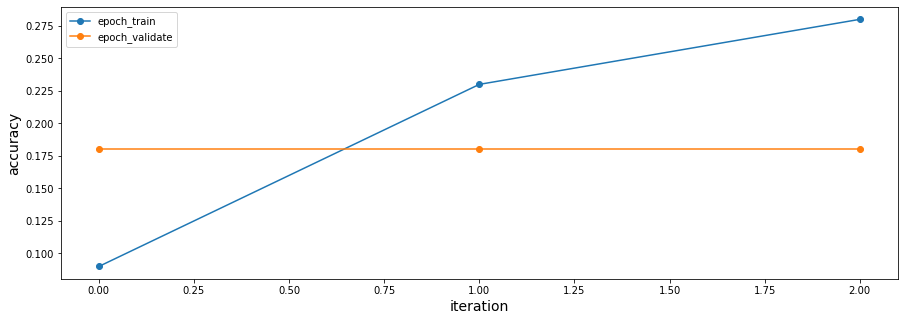

In [20]:
acc_sm = train_model(model_sm, criterion_sm, optimizer_sm, schedlr_sm,
                             loaders, sizes, device, num_epochs)
plot_accs({key: acc_sm[key] for key in ['epoch_train', 'epoch_validate']})

## Hinge loss (SVM)

In [21]:
model_mh = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, len(class_names))
    ).to(device)
optimizer_mh = optim.SGD(model_mh.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr_mh = lr_scheduler.StepLR(optimizer_mh, step_size=2, gamma=0.1) # lr decay
criterion_mh = nn.MultiMarginLoss()

train epoch: [1/3] Loss: 6.0834 ACC@1: 17.00%: 100%|██████████| 10/10 [01:01<00:00,  6.10s/it]
validate epoch: [1/3] Loss: 10.4482 ACC@1: 20.00%: 100%|██████████| 5/5 [00:28<00:00,  5.70s/it]
train epoch: [2/3] Loss: 6.6485 ACC@1: 35.00%: 100%|██████████| 10/10 [01:01<00:00,  6.20s/it]
validate epoch: [2/3] Loss: 10.6069 ACC@1: 24.00%: 100%|██████████| 5/5 [00:23<00:00,  4.65s/it]
train epoch: [3/3] Loss: 5.6371 ACC@1: 42.00%: 100%|██████████| 10/10 [01:03<00:00,  6.36s/it]
validate epoch: [3/3] Loss: 10.4726 ACC@1: 14.00%: 100%|██████████| 5/5 [00:22<00:00,  4.53s/it]



Returning best model, with validation accuracy 0.24


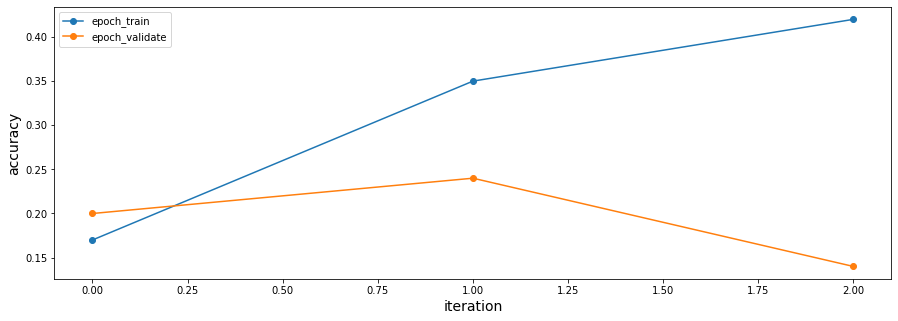

In [22]:
acc_mh = train_model(model_mh, criterion_mh, optimizer_mh, schedlr_mh,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_mh[key] for key in ['epoch_train', 'epoch_validate']})

## 2-layer fully connected net

In [23]:
hidden_layer_size = 4000

model_fc = nn.Sequential(
    Flatten(),
    nn.Linear(IMAGE_DIM*IMAGE_DIM*3, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, len(class_names))
    ).to(device)
optimizer_fc = optim.SGD(model_fc.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr_fc = lr_scheduler.StepLR(optimizer_fc, step_size=2, gamma=0.1) # lr decay
criterion_fc = nn.CrossEntropyLoss()

In [ ]:
acc_fc = train_model(model_fc, criterion_fc, optimizer_fc, schedlr_fc,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_fc[key] for key in ['epoch_train', 'epoch_validate']})

  0%|          | 0/10 [00:00<?, ?it/s]

## 3-layer ConvNet

In [ ]:
channel_1 = 32
channel_2 = 16

# padding chosen to preserve original H/W dimensions
model_cn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=channel_1, kernel_size=5, padding=(5 - 1)//2),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel_1, out_channels=channel_2, kernel_size=3, padding=(3 - 1)//2),
    nn.ReLU(), 
    Flatten(),
    nn.Linear(channel_2*IMAGE_DIM*IMAGE_DIM, len(class_names))
    ).to(device)
optimizer_cn = optim.SGD(model_cn.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr_cn = lr_scheduler.StepLR(optimizer_cn, step_size=2, gamma=0.1) # lr decay
criterion_cn = nn.CrossEntropyLoss()

In [ ]:
acc_cn = train_model(model_cn, criterion_cn, optimizer_cn, schedlr_cn,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_cn[key] for key in ['epoch_train', 'epoch_validate']})

## Summarize

In [ ]:
key = 'epoch_validate'

baseline_results = {
    'softmax': min(acc_sm[key]),
    'svm': min(acc_mh[key]),
    '2layer_fc': min(acc_fc[key]),
    '3layer_cnn':min(acc_cn[key])
}
baseline_results

# Transfer learning models

In [17]:
import torchvision.models as models
from notebooks.models import ResnetTransferClassifier
from notebooks.models import ConvnextTransferClassifier
from notebooks.models import TransformerTransferClassifier


m_resnetfc = ResnetTransferClassifier(num_classes=len(class_names), retrain_last_cnblock=False)
m_resnet = ResnetTransferClassifier(num_classes=len(class_names), retrain_last_cnblock=True)
m_convnext = ConvnextTransferClassifier(num_classes=len(class_names), retrain_last_cnblock=False)
m_trans = TransformerTransferClassifier(num_classes=len(class_names), retrain_last_encoder=False)

## Resnet

validate epoch: [3/3] Loss: 1.9837 ACC@1: 6.00%: 100%|██████████| 5/5 [00:40<00:00,  8.07s/it]



Returning best model, with validation accuracy 0.08


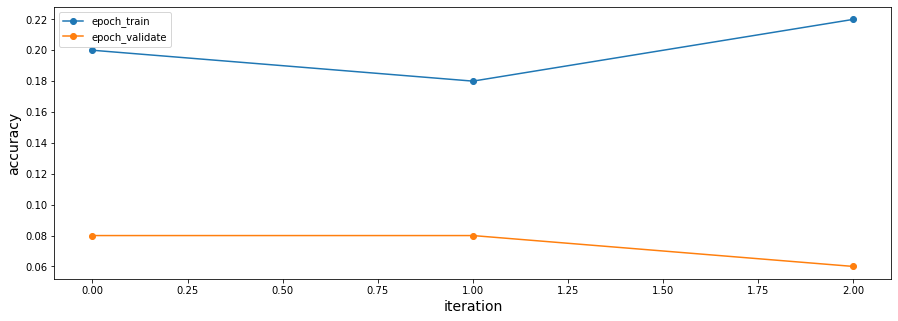

In [18]:
optimizer = optim.SGD(m_resnetfc.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_resfc = train_model(m_resnetfc, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_resfc[key] for key in ['epoch_train', 'epoch_validate']})

In [ ]:
optimizer = optim.SGD(m_resnet.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_res = train_model(m_resnet, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_res[key] for key in ['epoch_train', 'epoch_validate']})

## Convnext

validate epoch: [3/3] Loss: 1.9756 ACC@1: 12.00%: 100%|██████████| 5/5 [00:41<00:00,  8.37s/it]



Returning best model, with validation accuracy 0.14


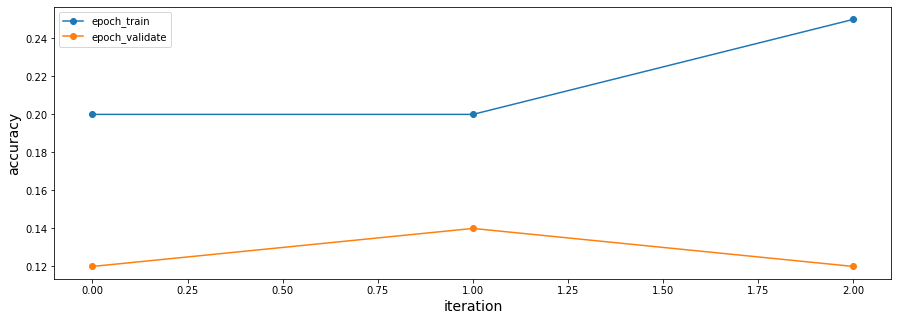

In [19]:
optimizer = optim.SGD(m_convnext.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_convnext = train_model(m_convnext, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_convnext[key] for key in ['epoch_train', 'epoch_validate']})

## Transformer

In [ ]:
optimizer = optim.SGD(m_trans.parameters(), lr=0.001, momentum=0.9, nesterov=True)
schedlr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay
criterion = nn.CrossEntropyLoss()
acc_trans = train_model(m_trans, criterion, optimizer, schedlr,
                                     loaders, sizes, device, num_epochs)
plot_accs({key: acc_trans[key] for key in ['epoch_train', 'epoch_validate']})

## Summarize

In [ ]:
key = 'epoch_validate'

transfer_results = {
    'resnet_fc': min(acc_resfc[key]),
    'resnet': min(acc_res[key]),
    'convnext': min(acc_convnext[key]),
    'transformer':min(acc_trans[key])
}
transfer_results

In [ ]:
%cd '/content/drive/My Drive /git/tree-finder'
!git config --global user.email "erich.j.trieschman@gmail.com"
!git config --global user.name "Erich Trieschman"

!git add .
!git commit -m 'transfer learning models'
!git push